## Import Libraries and Data

In [1]:
import numpy as np
#https://www.w3schools.com/python/numpy_intro.asp
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [2]:
from google.colab import files as file
ab_data_file = file.upload()

Saving ab_data.csv to ab_data.csv


This dataset contains the result of an A/B test where two groups, the control group and the treatment group, were exposed to an old webpage and a new webpage respectively.

In [3]:
df = pd.read_csv('ab_data.csv',header=0,sep=',')
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


## Data Wrangling

In [4]:
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

Above, you can see that there seems to be an error where some users in the control group saw the new page and some users in the treatment group saw the old page. Since I wasn’t sure which way to revert the misclassified users, I decided to remove it with the code below.

In [5]:
df_cleaned = df.loc[(df['group']=='control') & (df['landing_page']=='old_page') | (df['group']=='treatment') & (df['landing_page']=='new_page')]
df_cleaned.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [6]:
#Checking duplicated values
df_cleaned['user_id'].duplicated().sum()

1

In [7]:
#Finding the duplicated user
df_cleaned[df_cleaned.duplicated(['user_id'],keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [8]:
#Keep the user first instance only
df_cleaned=df_cleaned.drop_duplicates(subset=['user_id'],keep='first')
df_cleaned['user_id'].duplicated().sum()

0

## Exploratory Data Analysis (EDA)

Plotting the data against a bar chart to see what the proportion of conversions was for both groups. It appears that they have similar conversion rates (approx. 1/7)

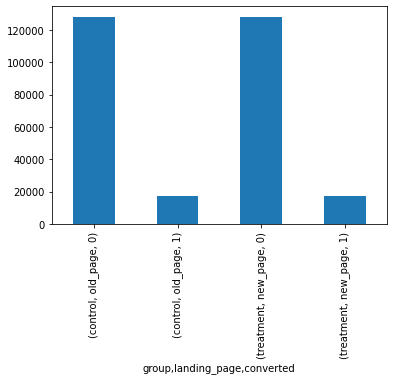

In [9]:
df_cleaned.groupby(['group','landing_page','converted']).size().plot.bar()
#size returns the number of elements in this object

Proportion between the number of users in each group

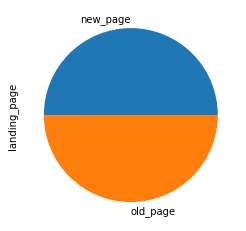

In [10]:
df_cleaned['landing_page'].value_counts().plot.pie()

## Data Preparation

In [18]:
#Re-organizing the groups to perform the calculations
a = df_cleaned[df_cleaned['group']=='control']
b = df_cleaned[df_cleaned['group']=='treatment']

#Calculations for all possibilities
a_click = a.converted.sum() #sum all the values 1 (converted)
a_noclick = a.converted.size - a.converted.sum() #size is the total number of observations
b_click = b.converted.sum()
b_noclick = b.converted.size - b.converted.sum()

#Creta numpy array, which assumes the format of a contingency table (input for scipy.stats.chi2_contingency)
T = np.array([[a_click, a_noclick], [b_click, b_noclick]])
print(T)

[[ 17489 127785]
 [ 17264 128046]]


## Chi-Squared Test

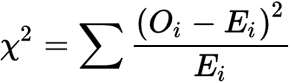

- O = observed
- E = expected

What do click-through rates and conversions have in common? They have a Bernoulli Distribution, the discrete probability distribution that has a probability of being 1 and a probability of being 0. For click-through rates, a user will either click (1) or not click (0). Similarly, for conversions, a user will either convert (1) or not convert (0).

In [25]:
from scipy import stats

#To find out more details about chi2_contingency, visit: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html
x2 = scipy.stats.chi2_contingency(T,correction=False)
print(x2[1]) #We are interested in the p-value, returned in index 1

0.18988337448194853


### Conclusions

P-value is 19%. Thus, considering 5% as the level of significance, the null hypothesis cannot be rejected. In other words, this means that there is no significance in conversions between the old and new webpage.